(All code source are cited in the code cell)
# 1. Linear Regression Analysis for Wine Quality
(1) Show the results of regression analysis as follows
* Regression output:

|                      | estimate | std. err | t-value | p-value |
|----------------------|----------|----------|---------|---------|
| Intercept            | 21.9652  | 21.195   | 1.036   | 0.300   |
| fixed acidity        | 0.0250   | 0.026    | 0.963   | 0.336   |
| volatile acidity     | -1.0836  | 0.121    | -8.948  | 0.000   |
| citric acid          | -0.1826  | 0.147    | -1.240  | 0.215   |
| residual sugar       | 0.0163   | 0.015    | 1.089   | 0.276   |
| chlorides            | -1.8742  | 0.419    | -4.470  | 0.000   |
| free sulfur dioxide  | 0.0044   | 0.002    | 2.009   | 0.045   |
| total sulfur dioxide | -0.0033  | 0.001    | -4.480  | 0.000   |
| density              | -17.8812 | 21.633   | -0.827  | 0.409   |
| pH                   | -0.4137  | 0.192    | -2.159  | 0.031   |
| sulphates            | 0.9163   | 0.114    | 8.014   | 0.000   |
| alcohol              | 0.2762   | 0.026    | 10.429  | 0.000   |

R-squared: 0.361, Adjusted R-squared: 0.356

In [3]:
# build model and print summary
# code source: https://datatofish.com/multiple-linear-regression-python/
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
data = pd.read_excel("MDS_Assignment1_winequality.xlsx")

x = data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
y = data['quality']
regr = linear_model.LinearRegression()
regr.fit(x, y)
x = sm.add_constant(x) # adding a constant
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     81.35
Date:                Tue, 03 Oct 2023   Prob (F-statistic):          1.79e-145
Time:                        12:16:39   Log-Likelihood:                -1569.1
No. Observations:                1599   AIC:                             3162.
Df Residuals:                    1587   BIC:                             3227.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   21.9652 

(2) The fitting of the linear regression is a good idea? If yes, why? If no, why? What’s the possible reason of poor fitting? 

Based on the R-squared and adjusted R-squared values, the model can only account for 30% of the variance in the data. This is clearly not a favorable result. Upon examining the table, it becomes apparent that the p-values of six variables in the dataset exceed the threshold of 0.01. Consequently, the presence of variables that the model cannot adequately explain may adversely impact its overall interpretability. Furthermore, it is imperative to assess whether the data meets the three assumptions of regression.

(3) Based on the results, rank the independent variables by p-values and which one are statistically significant variables with p-values<0.01? (i.e. 重要變數挑選)
* Ranked Independent Variables: alcohol, volatile acidity, sulphates, total sulfur dioxide, chlorides, pH, free sulfur dioxide, citric acid, residual sugar, fixed acidity, density
* Statistically Significant Variables (p-values<0.01): alcohol, volatile acidity, sulphates, total sulfur dioxide, chlorides

In [4]:
# print out sorted variables by p-values
print(sorted(model.pvalues.items(), key = lambda x:x[1])) 

[('alcohol', 1.1230286392998289e-24), ('volatile acidity', 9.872361224126673e-19), ('sulphates', 2.1272284436645484e-15), ('total sulfur dioxide', 8.004609818322441e-06), ('chlorides', 8.373953383609647e-06), ('pH', 0.03100188619378898), ('free sulfur dioxide', 0.04474495077350595), ('citric acid', 0.2149942460702454), ('residual sugar', 0.27649596112965674), ('const', 0.30019213584215976), ('fixed acidity', 0.3356527522715964), ('density', 0.4086078971933953)]


(4) Testify the underlying assumptions of regression (1) Normality, (2) Independence, and (3) Homogeneity of Variance with respect to residual.

By observing the `model.summary()` text in problem 1-1, we can conclude that:
* Normality: The p-value of Omnibus test and JB test are both smaller than 0.001, so it appears that the assumption of normality of residuals is violated.
* Independence: The Durbin-Watson statistic of 1.757 falls outside the interval of 1.870-1.898 provided by the Durbin-Watson Table for n = 1600 and k = 11. This suggests the presence of potential positive autocorrelation in the residuals. 
    
    source: https://real-statistics.com/statistics-tables/durbin-watson-table/
* Homogeneity: The p-value of the White Test is way below 0.01, indicating rejection to null hypothesis. The residuals have Heteroscedasticity.

In [5]:
# Checking Homogeneity
# code source: https://medium.com/analytics-vidhya/how-to-check-for-assumptions-in-a-linear-regression-a68116aef88a
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip

#The test
white_test = het_white(model.resid,  model.model.exog)
#Zipping the array with labels
names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
lzip(names,white_test)

[('Lagrange multiplier statistic', 290.0129890631725),
 ('p-value', 1.896219858332003e-26),
 ('f-value', 4.376436195888247),
 ('f p-value', 5.3292140793709454e-30)]

# 2.  Association Rule- Market Basket Analysis
(1) How to handle the raw dataset via data preprocessing?

To prepare the data for the Apriori Algorithm, it's essential to group it by "InvoiceNo" and perform one-hot encoding on "StockCode". Additionally, removing other columns helps enhance execution time.

In [6]:
# code source: https://stackoverflow.com/questions/46791626/one-hot-encoding-multi-level-column-data
data_2 = pd.read_excel("MDS_Assignment1_OnlineRetail.xlsx")
data_2 = data_2[['InvoiceNo']].join(pd.get_dummies(data_2['StockCode'])).groupby('InvoiceNo').max()

(2) Define and what’s the top 10 association rules? Show the support, confidence, and
lift to each specific rule, respectively?

| antecedents               | consequents           |   support |   confidence |   lift |
|:--------------------------|:----------------------|----------:|-------------:|-------:|
| 23172        | 23171    | 0.010888  |     0.898089 |     60 |
| 23171        | 23172    | 0.010888  |     0.73057  |     60 |
| 23172        | 23170    | 0.0105019 |     0.866242 |     49 |
| 22746        | 22745    | 0.0101158 |     0.793939 |     48 |
| 22745        | 22746    | 0.0101158 |     0.615023 |     48 |
| 23171        | 23170    | 0.0124324 |     0.834197 |     47 |
| 22746        | 22748    | 0.0101544 |     0.79697  |     47 |
| 23170        | 23171    | 0.0124324 |     0.704595 |     47 |
| 21080, 21086 | 21094    | 0.0102317 |     0.89527  |     44 |
|  47590A      |  47590B  | 0.0101931 |     0.671756 |     44 |

Association Rules Filtering Procedure:
1. Apply the Apriori Algorithm to identify frequent itemsets with a minimum support of 0.01. The slight adjustment was made to accommodate memory limitations.
2. Further refine the results by filtering with a minimum confidence threshold of 0.6.
3. Eliminate association rules that involve single items (1-itemset).
4. Sort the remaining rules based on two criteria: `'lift'` and `'confidence'`. For `'lift'`, round the values to integers to prioritize improved confidence while maintaining a similar level of lift.

In [7]:
# code source: https://artsdatascience.wordpress.com/2019/12/10/python-%E5%AF%A6%E6%88%B0%E7%AF%87%EF%BC%9Aapriori-algorithm/
from mlxtend.frequent_patterns import apriori
frequent_itemset = apriori(data_2, min_support=0.01, use_colnames=True) # get frequent itemset
# frequent_itemset.to_csv('D:/作業/製造數據科學/MDS_Assignment01/apriori.csv')
from mlxtend.frequent_patterns import association_rules
associationRules = association_rules(frequent_itemset, metric="confidence", min_threshold=0.6) # confidence threshold

In [81]:
# associationRules = pd.read_csv("D:/作業/製造數據科學/MDS_Assignment01/association.csv")

# Get itemset having >= 2 items
ResultRules = associationRules.loc[:]
# ResultRules['antecedents_len'] = ResultRules['antecedents'].apply(lambda x:len(x))
# ResultRules['consequents_len'] = ResultRules['consequents'].apply(lambda x:len(x))
# print(ResultRules)
# ResultRules = ResultRules[ResultRules['antecedents_len'] >= 2]

ResultRules['lift'] = ResultRules['lift'].apply(lambda x: round(x, 0)) # round the lift to integer
ResultRules.sort_values(['lift', 'confidence'], ascending=False).head(10) #sort the rules

antecedents consequents  antecedent support  consequent support  \
49          (23172)     (23171)            0.012124            0.014903   
48          (23171)     (23172)            0.014903            0.012124   
47          (23172)     (23170)            0.012124            0.017645   
39          (22746)     (22745)            0.012741            0.016448   
38          (22745)     (22746)            0.016448            0.012741   
46          (23171)     (23170)            0.014903            0.017645   
42          (22746)     (22748)            0.012741            0.016988   
45          (23170)     (23171)            0.017645            0.014903   
135  (21080, 21086)     (21094)            0.011429            0.020347   
58         (47590A)    (47590B)            0.015174            0.015367   

      support  confidence  lift  leverage  conviction  zhangs_metric  
49   0.010888    0.898089  60.0  0.010707    9.666260       0.995474  
48   0.010888    0.730570  60.0  0.010707    3.666541       0.998283  
47   0.010502    0.866242  49.0  0.010288    7.344275       0.991653  
39   0.010116    0.793939  48.0  0.009906    4.773121       0.991922  
38   0.010116    0.615023  48.0  0.009906    2.564465       0.995660  
46   0.012432    0.834197  47.0  0.012169    5.924830       0.993657  
42   0.010154    0.796970  47.0  0.009938    4.841699       0.991314  
45   0.012432    0.704595  47.0  0.012169    3.334734       0.996430  
135  0.010232    0.895270  44.0  0.009999    9.354101       0.988570  
58   0.010193    0.671756  44.0  0.009960    2.999697       0.992180

(3) Please provide/guess the “story” to interpret one of top-10 rules you are interested in (Third column in dataset shows item Description).

* Select the Rule with two antecedents: Choose the highest-ranked association rule involving `'SET/20 RED RETROSPOT PAPER NAPKINS' (21080)` and `'SET/6 RED SPOTTY PAPER CUPS' (21086)` related to `'SET/6 RED SPOTTY PAPER PLATES' (21094)`.
* Story Explanation: The rule suggests a connection between these three items. Specifically, it associates the "Red Retrospot" style with a lively and celebratory ambiance. Additionally, it highlights the utility of napkins, paper cups and paper plates, commonly used in settings like restaurants, parties, or banquets. Therefore, we can interpret this rule as indicating that individuals planning events or gatherings with a festive atmosphere are likely to purchase both of these items for their food and beverage needs.

(4) Give a visualization graph of your association rules

Here provides a heatmap with lift:

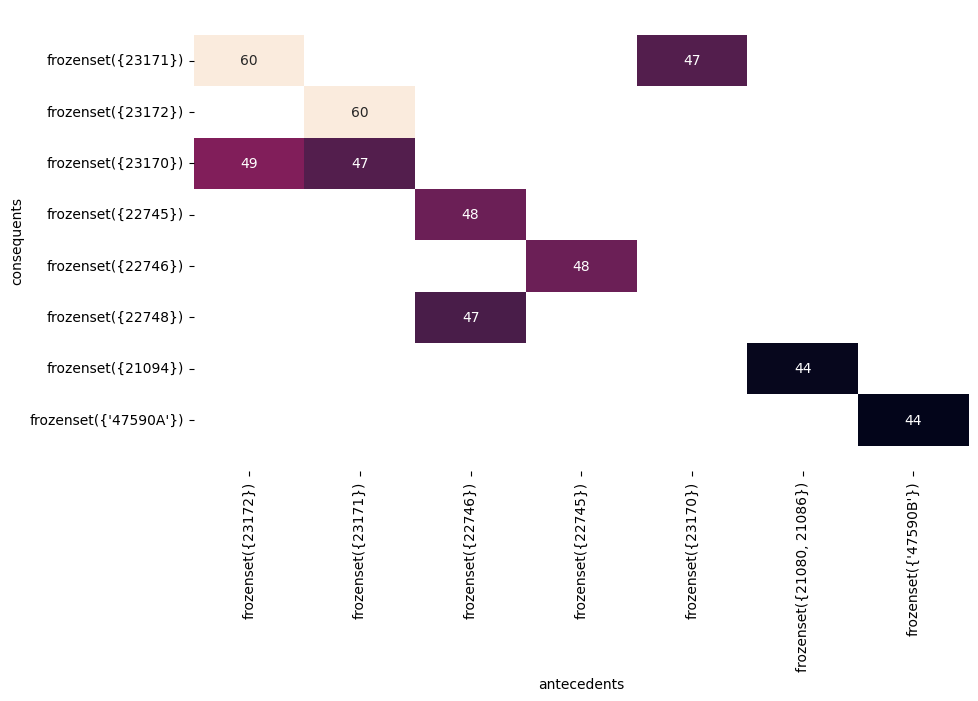

In [82]:
# code source: https://goldinlocks.github.io/Market-Basket-Analysis-in-Python/
import matplotlib.pyplot as plt
import seaborn as sns

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = associationRules.iloc[[49, 48, 47, 39, 38, 46, 42, 45, 135, 57]].pivot(index = 'consequents', columns = 'antecedents', values= 'lift')
# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot = True, cbar = False)
b, t = plt.ylim() 
b += 0.5 
t -= 0.5 
plt.ylim(b, t) 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

# 3. Manufacturing System Analysis
(1) 根據 Little’s Law，試計算各工作站的產出率 TH 於下表；試問瓶頸站的產出率 𝑟𝑏、最小生產週期時間(總加工時間，𝑇0)、關鍵在製品水準(𝑊0)各為多少？

| 工作站編號  | 平行等效機台數  |加工時間(小時) |工作站的產能 TH(個/小時) |
|:-------------:|:------------:|:----------:|:-------------:|
| 1        | 5    | 7  |     5/7 |
| 2        | 2    | 3  |    2/3  |
| 3        | 6    | 15 |     2/5 |
| 4        | 3    | 5 |     3/5 |

瓶頸站為編號3，瓶頸站的產出率 𝑟𝑏 = 0.4, 𝑇0 = 30, 𝑊0 = 12

(2) 試給出最佳績效(best case)下，最大的產出率(THbest)與最小生產週期時間(CTbest)的計算公式(提示：參閱講義)
```python
def CTbest(w):
    if(w <= W_0): return T_0
    else: return w / r_b

def THbest(w):
    if(w <= W_0): return w / T_0
    else: return r_b
```
(3)根據該問題的產線，試程式撰寫建立一模擬模型(或用套裝軟體、數值分析)來驗證，當在製品 WIP 數量超過工廠產能時，其生產週期將嚴重惡化。也就是當產線的投料速度(投產量)大於產線的產出率，此時生產系統將處於非穩態的狀態(non-steady state)。試用圖表呈現 WIP、CT 與 TH 之間惡化的關係。(提示：參閱講義)

本模擬週期為放進 1000 倍的當前在製品數量（例如若在製品為 5，則在產線始終維持 5 個在製品的狀況下陸續放進 5000 個在製品，跑完 1000 個週期），並且於最後一個產品生產完成之後結束，以得到合理的 CT，減少受到前幾批次的在製品的週期影響，由下面兩張折線圖可以發現，𝑊0 為 12，THbest 約為 0.3999，CTbest 約 30.01 小時，與先前第一小題得出的理論值相符。


[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,

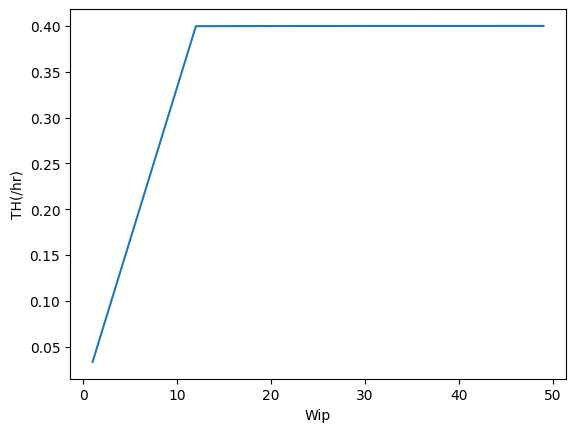

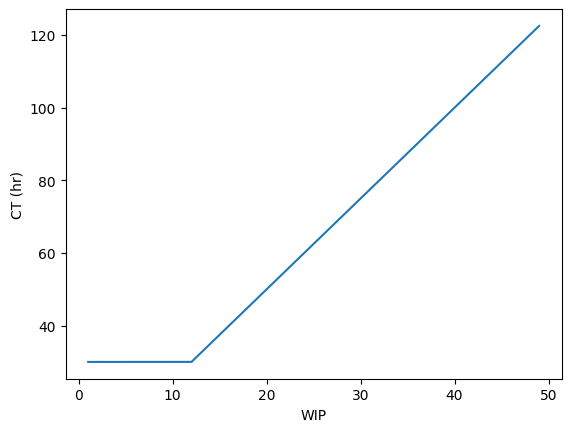

In [1]:
class WorkStation:
    def __init__(self, StationNo, T_0):
        self.StationNo = StationNo # 平行工作站數量
        self.T_0 = T_0 # 該工作站的加工時間
        self.WorkingHr = [] # 當前各工作站在製品已加工時間
        self.isWorking = [] # 當前各工作站是否在加工
        for i in range(StationNo):
            self.isWorking.append(False)
            self.WorkingHr.append(0)
        self.standby = 0 # 當前有多少在製品在等待
    
    def add(self, input_num): # 投入在製品
        self.standby += input_num 
    
    def update(self): # 每增加一小時，更新一次該工作站產線狀況
        finished_num = 0
        for i in range(len(self.WorkingHr)):
            if(self.standby > 0 and (not self.isWorking[i])):
                self.isWorking[i] = True
                self.standby -= 1
            if(self.isWorking[i]):
                self.WorkingHr[i] += 1
            if(self.WorkingHr[i] == self.T_0):
                self.WorkingHr[i] = 0
                finished_num += 1
                self.isWorking[i] = False
        return finished_num
    
    def getStandby(self): 
        return self.standby

Wip = []
Ct = []
Th = []
cycle = 1000
for w in range(1, 50):
    wip = [] # 各個產品的CT
    wipnum = 0 # 第幾個產品被完成
    CTtotal = 0 # 所有產品的 CT 加總
    
    for i in range(w): wip.append(0) # 設定第一批投進去的在製品起始時間為 hr = 0

    hr = 0 # 當前是第幾個小時
    final = 0 # 完成的在製品數量

    Station = [WorkStation(5, 7), WorkStation(2, 3), WorkStation(6, 15), WorkStation(3, 5)] # 工作站的list
    Station_standby = [0, 0, 0] # 第2, 3, 4個工作站這一個小時完成的產品
    Station[0].add(w) # 第一個工作站投入第一批在製品
    while True:
        hr += 1
        for i in range(len(Station) - 1): # 儲存前三個工作站的半成品
            Station_standby[i] = Station[i].update()
        
        temp = Station[3].update() # 儲存產線的完成品
        for i in range(temp):
            CTtotal += hr - wip[wipnum]
            wip[wipnum] = hr - wip[wipnum] # 當前時間 - 進入產線時間 = CT
            wipnum += 1
            wip.append(hr)
            Station[0].add(1) # 因有完成品，第一工作站再補放入產品維持在製品水準
        final += temp
        
        for i in range(len(Station_standby)):
            Station[i + 1].add(Station_standby[i]) # 將對應的半成品加入下一個工作站

        if(final >= cycle * w): 
            for i in range(len(wip) - cycle * w):
                wip.pop()
            break
    
    print(wip) # 印出每個產品加工的時間
    Wip.append(w)
    CT = CTtotal / (cycle * w) # 計算平均CT
    Ct.append(CT)
    Th.append(w / (CT))
    print('WIP = ', w, 'CT = ', round(CT, 2), 'TH = ', w / (CT))

plt.plot(Wip, Th)
plt.xlabel('Wip')
plt.ylabel('TH(/hr)')
plt.show()

plt.plot(Wip, Ct)
plt.xlabel('WIP')
plt.ylabel('CT (hr)')
plt.show()